In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from tqdm import tqdm_notebook as tqdm
import pickle
from pathlib import Path
from nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix
from lyft_dataset_sdk.eval.detection import mAP_evaluation

In [3]:
import torch
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import build_network, example_convert_to_torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

## Read Config file

In [4]:
torch.set_num_threads(10)

#config_path = "configs/nuscenes/all.fhd.config"
config_path = "/home/ags/second_test/all.fhd.2/pipeline.config"
ckpt_path = "/home/ags/second_test/all.fhd.2/voxelnet-42898.tckpt"

config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [6]:
root = '/media/ags/DATA/CODE/kaggle/lyft-3d-object-detection/'
# info_path = input_cfg.dataset.kitti_info_path # val set info
# root_path = input_cfg.dataset.kitti_root_path # data/lyft/train

info_path = root + 'data/lyft/test/infos_test.pkl'
root_path = root + 'data/lyft/test/'

# info_path = '../../data/lyft/train/old-bk/infos_val.pkl'
# info_path = root + 'data/lyft/train/infos_val.pkl'

with open(info_path, 'rb') as f:
    infos = pickle.load(f)


In [7]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info

In [8]:
net = build_network(config.model.second).to(device).float().eval()
net.load_state_dict(torch.load(ckpt_path))
eval_input_cfg = config.eval_input_reader
eval_input_cfg.dataset.kitti_root_path = root_path
eval_input_cfg.dataset.kitti_info_path = info_path
batch_size = 4
num_workers = 4
dataset = input_reader_builder.build(
    eval_input_cfg,
    config.model.second,
    training=False,
    voxel_generator=net.voxel_generator,
    target_assigner=net.target_assigner)#.dataset
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size, # only support multi-gpu train
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    collate_fn=merge_second_batch)


target_assigner = net.target_assigner
voxel_generator = net.voxel_generator
classes = target_assigner.classes

feature_map_size [1, 124, 124]


### utility functions

In [9]:
def thresholded_pred(pred, threshold):
    try:
        box3d = pred["box3d_lidar"].detach().cpu().numpy()
        scores = pred["scores"].detach().cpu().numpy()
        labels = pred["label_preds"].detach().cpu().numpy()
    except:
        box3d = pred["box3d_lidar"]#.detach().cpu().numpy()
        scores = pred["scores"]#.detach().cpu().numpy()
        labels = pred["label_preds"]#.detach().cpu().numpy()       
    idx = np.where(scores > threshold)[0]
    # filter low score ones
    box3d = box3d[idx, :]
    # label is one-dim
    labels = np.take(labels, idx)
    scores = np.take(scores, idx)
    pred['box3d_lidar'] = box3d
    pred['scores'] = scores
    pred['label_preds'] = labels
    return pred

In [10]:
def to_glb(box, info):
    # lidar -> ego -> global
    # info should belong to exact same element in `gt` dict
    box.rotate(Quaternion(info['lidar2ego_rotation']))
    box.translate(np.array(info['lidar2ego_translation']))
    '''
    # filter det in ego.
    cls_range_map = eval_detection_configs[eval_version]["class_range"]
    radius = np.linalg.norm(box.center[:2], 2)
    det_range = cls_range_map[classes[box.label]]
    if radius > det_range:
        continue
    '''
    box.rotate(Quaternion(info['ego2global_rotation']))
    box.translate(np.array(info['ego2global_translation']))
    return box

In [11]:
def get_pred_str(pred, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            token=sample_token
        )
        #return box
        box = to_glb(box, info)
        pred =  str(box.score) + ' ' + str(box.center[0])  + ' '  + \
                str(box.center[1]) + ' '  + str(box.center[2]) + ' '  + \
                str(box.wlh[0]) + ' ' \
                + str(box.wlh[1]) + ' '  + str(box.wlh[2]) + ' ' + str(box.orientation.yaw_pitch_roll[0]) + ' ' \
                + str(name) + ' ' 
        pred_str += pred
    return pred_str.strip()


In [12]:

detections = []
#tokens = []
tk0 = tqdm(dataloader, total=len(dataloader))
for idx, examples in enumerate(tk0):
    try:
        example_torch = example_convert_to_torch(examples, device=device)
        detections += net(example_torch)
    except Exception as e:
        print(e)
        import pdb; pdb.set_trace()

100%|██████████| 6867/6867 [24:34<00:00,  4.66it/s]


In [14]:
df = pd.read_csv(root + 'data/lyft/sample_submission.csv')
# df = pd.read_csv(root + 'data/lyft/train.csv')

In [17]:
threshold = 0.5
for idx, pred in enumerate(tqdm(detections)):
    pred = thresholded_pred(pred, threshold)
    token = pred['metadata']['token']
    pred_str = get_pred_str(pred, token)
    index = df[df['Id'] == token].index[0]
    df.loc[index, 'PredictionString'] = pred_str
#     df.loc[index, 'PredictionStringtest'] = pred_str


  0%|          | 0/27468 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [16]:
df.to_csv('submissions/sub.all.fhd.2.csv', index=False)

In [13]:
df.head()

,Id,PredictionString,PredictionStringtest
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,0.9132686257362366 2719.266457575167 690.86441...
1,edf37c1fb1024ba0c1f53ebbf10b6797f781199a9f0e4e...,1208.642684768659 1585.1812946970927 -23.56236...,NaN
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,0.9026079177856445 872.4775161488055 2564.1953...
3,a970c764e7abd7ebc2cc4599a6e3ae58c9773ea3c9cf1d...,1994.4320280494098 1128.30164336183 -18.054752...,NaN
4,b909de93ba19460eeea58074ccc1ef6bb302435f37b48c...,1030.3877156973385 1667.13131694941 -23.764820...,NaN


In [15]:
val_df = df[df.PredictionStringtest.notna()]

In [16]:
val_df.shape

(4032, 3)

In [47]:
# val_df.to_csv('submissions/all.fhd.2.val.csv', index=False)

### testing on val set

make sure to match kernel is predicting on train or val which one

In [34]:
phase = 'train'
data = 'v1.0-trainval' if phase=='train' else 'v1.0-test'
lyft = LyftDataset(data_path=f'../../data/lyft/{phase}/', json_path=f'../../data/lyft/{phase}/{data}/', verbose=0) 
##nusc = NuScenes(dataroot=f'../../data/lyft/{phase}/', version=data, verbose=0) 

In [53]:
# info_path = input_cfg.dataset.kitti_info_path
# root_path = Path(input_cfg.dataset.kitti_root_path)
# info_path = '../../data/lyft/test/infos_test.pkl'
# root_path = '../../data/lyft/test/'

classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']
res_path = '/home/ags/second_test/all_fhd.30/results/step_29325/result.pkl'
info_path = '../../data/lyft/train/old-bk/infos_val.pkl'
with open(res_path, 'rb') as f:
    results = pickle.load(f)#['infos']
    
with open(info_path, 'rb') as f:
    gt = pickle.load(f)['infos']
#df = pd.read_csv('../../data/lyft/sample_submission.csv')
df = pd.read_csv('../../data/lyft/train.csv')

# info_val.pkl and result.pkl are a list of dictionaries, which are out of order, sorting them acc to token
gt = sorted(gt, key=lambda x: x['token'])
results = sorted(results, key=lambda x: x['metadata']['token'])
# sanity check
for i in range(len(gt)):
    assert gt[i]['token'] == results[i]['metadata']['token']
    results[i]['box3d_lidar'] = results[i]['box3d_lidar']#.detach().cpu().numpy()
    results[i]['scores'] = results[i]['scores'].detach()#.cpu().numpy()
    results[i]['label_preds'] = results[i]['label_preds']#.detach().cpu().numpy()


In [40]:
token2idx = {} # to match up with kernel_pred_boxes
for i in range(len(gt)):
    token2idx[gt[i]['token']] = i

In [41]:
def get_pred_boxes(pred, sample_token):
    boxes_lidar = pred["box3d_lidar"]
    boxes_class = pred["label_preds"]
    scores = pred['scores']
    preds_classes = [classes[x] for x in boxes_class]
    box_centers = boxes_lidar[:, :3]
    box_yaws = boxes_lidar[:, -1]
    box_wlh = boxes_lidar[:, 3:6]
    info = token2info[sample_token] # a `sample` token
    boxes = []
    pred_str = ''
    for idx in range(len(boxes_lidar)):
        translation = box_centers[idx]
        yaw = - box_yaws[idx] - pi/2
        size = box_wlh[idx]
        name = preds_classes[idx]
        detection_score = scores[idx]
        label = boxes_class[idx]
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        box = Box(
            center=box_centers[idx],
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=sample_token
        )
        boxes.append(box)
    return boxes
    '''
        box = to_glb(box, info)
        pred =  str(box.score) + ' ' + str(box.center[0])  + ' '  + \
                str(box.center[1]) + ' '  + str(box.center[2]) + ' '  + \
                str(box.wlh[0]) + ' ' \
                + str(box.wlh[1]) + ' '  + str(box.wlh[2]) + ' ' + str(box.orientation.yaw_pitch_roll[0]) + ' ' \
                + str(name) + ' ' 
        pred_str += pred
    return pred_str.strip()
    '''
    


In [55]:
threshold = 0.3
token2predstr = {}
for idx in tqdm(range(len(dataset))):
    idx=100
    example = dataset[idx]
    token = example['metadata']['token']
    #print('token:', token)
    # don't forget to pad batch idx in coordinates
    example["coordinates"] = np.pad(
        example["coordinates"], ((0, 0), (1, 0)),
        mode='constant',
        constant_values=0)
    # don't forget to add newaxis for anchors
    example["anchors"] = example["anchors"][np.newaxis, ...]

    example_torch = example_convert_to_torch(example, device=device)
    pred = net(example_torch)[0]
    pred = thresholded_pred(pred, threshold)
    sample_token = example['metadata']['token']
    kernel_pred_boxes = get_pred_boxes(pred, sample_token)
    break
pkl_idx = token2idx[token] 
idx, pkl_idx

  0%|          | 0/4158 [00:00<?, ?it/s]


(100, 437)

we have `kernel_pred_boxes` predicted on given `idx` and `token` by this kernel, we have `results[pkl_idx]` predicted during training, we have ground truth in `gt[pkl_idx]['gt_boxes']` as actual ground truth + lyft.get_boxes for ground truth, all in lidar's FoR

In [66]:

info_gt = gt[pkl_idx].copy() # during training predictions
info_gt['gt_boxes'].shape
info_gt['gt_boxes'].shape
gt[0].keys()

dict_keys(['lidar_path', 'cam_front_path', 'token', 'sweeps', 'lidar2ego_translation', 'lidar2ego_rotation', 'ego2global_translation', 'ego2global_rotation', 'timestamp', 'gt_boxes', 'gt_names', 'gt_velocity', 'num_lidar_pts', 'num_radar_pts'])

In [67]:
def gt2Box(gt_boxes, gt_names, token):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = - gt_boxes[idx, 6] - pi/2
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes


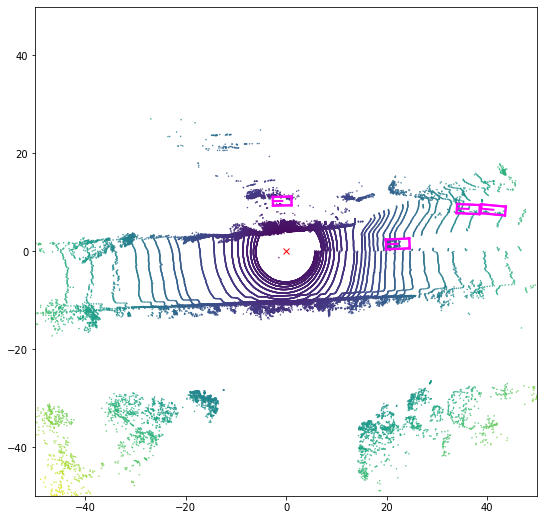

In [73]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
info = token2info[token]

dt_pred = results[pkl_idx].copy() # during training predictions
dt_pred = thresholded_pred(dt_pred, threshold)
dt_pred_boxes = get_pred_boxes(dt_pred, token)

gt_info = gt[pkl_idx]
info_gt_boxes = gt_info['gt_boxes'].copy() # during training predictions
info_gt_names = gt_info['gt_names'].copy() # during training predictions
info_gt_boxes = gt2Box(info_gt_boxes, info_gt_names, token)

v_path = info["lidar_path"]
points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)

# plot kernel predictions
for pbox in kernel_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('cone')) / 255.0 # black
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot detection results.pkl 
for pbox in dt_pred_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('pedestrian')) / 255.0 # Blue 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 
    
# plot ground truth from info.pkl 
for pbox in info_gt_boxes:
#     print(pbox)
    break
    c = np.array(lyft.explorer.get_color('vehicle.bicycle')) / 255.0 # Red 
    pbox.render(ax, view=np.eye(4), colors=(c, c, c)) 

lidar_token = lyft.get('sample', info['token'])['data']['LIDAR_TOP']
_, gt_boxes, _ = lyft.get_sample_data(lidar_token, flat_vehicle_coordinates=False) # notice flat_vehicle_coordinates=False 
for box in gt_boxes:
#     print(box)
#     break
    c = np.array(lyft.explorer.get_color('animal')) / 255.0 # magenta 
    box.render(ax, view=np.eye(4), colors=(c, c, c))

##### Conclusion

* The `results.pkl` generated during training are more or less same as predictions made by this kernel
* my pred boxes to Box conversion code is perfect :D, because gt_boxes matches with lyft.get_boxes()

### What next?
* predict on val set, get them to global, compare with ground truth predstring


In [22]:
# let's transform boxes from lidar's FoR to global FoR
glb_pboxes = [to_glb(box, info) for box in pred_boxes]
glb_gboxes = [to_glb(box, info) for box in gt_boxes]

In [26]:

def toBox3D(box, info):
    return mAP_evaluation.Box3D(
                sample_token=info['token'],
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

In [27]:
pboxes = [toBox3D(box, info).serialize() for box in glb_pboxes]
gboxes = [toBox3D(box, info).serialize() for box in glb_gboxes]

In [28]:
iou_threshold = 0.5
# average_precisions = mAP_evaluation.get_average_precisions(gboxes, pboxes, classes, iou_threshold)
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [30]:
for key in gt_by_class_name.keys():
    print('gt:', key, len(gt_by_class_name[key]))
for key in pred_by_class_name.keys():
    print('pred', key, len(pred_by_class_name[key]))

gt: other_vehicle 5
gt: car 30
gt: bus 2
pred car 19
pred other_vehicle 2


In [32]:
average_precisions = np.zeros(len(classes))

for class_id, class_name in enumerate(classes):
    if class_name in pred_by_class_name and class_name in gt_by_class_name:
        recalls, precisions, average_precision = mAP_evaluation.recall_precision(
            gt_by_class_name[class_name], pred_by_class_name[class_name], iou_threshold
        )
        average_precisions[class_id] = average_precision
        

In [33]:
average_precisions

array([0.52745098, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### val df pred vs gt

In [17]:
# pred_df = pd.read_csv('final1.csv')
pred_df = val_df.copy()

In [18]:
pred_df.head()

,Id,PredictionString,PredictionStringtest
0,db8b47bd4ebdf3b3fb21598bb41bd8853d12f8d2ef25ce...,2680.2830359778527 698.1969292852777 -18.04776...,0.9132686257362366 2719.266457575167 690.86441...
2,1841b7895e7163a2c1be87e8c1740e759a910cd59157b8...,848.9346793681768 2587.2870557176507 -20.15995...,0.9026079177856445 872.4775161488055 2564.1953...
5,4131c08a60bb7ad7fa66beb76f609d478571d508075a5a...,2775.313471140576 647.6817293876779 -18.164804...,0.9325973987579346 2681.6541244227205 705.8557...
8,7ff737ffb6f4d3adc01934f07178002543b6aab2352b1e...,2057.870673628988 1069.1471751137874 -18.38568...,0.9309068918228149 2030.8163891821255 1078.934...
9,5796b008cea965d2ff1d8f653d93b5d29aed64c22d6b89...,1426.2092077593366 1476.2266591045304 -21.5862...,0.914925217628479 1423.4485303394708 1473.6644...


In [19]:
sample_token = pred_df.iloc[0]['Id']
ps = pred_df.iloc[0]['PredictionString']
ps = ps.split()
gt_objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
ps = pred_df.iloc[0]['PredictionStringtest']
ps = ps.split()
pred_objects = [ps[x:x+9] for x in range(0, len(ps), 9)]

In [20]:
len(gt_objects), len(pred_objects), gt_objects[0], pred_objects[0]

(52,
 37,
 ['2680.2830359778527',
  '698.1969292852777',
  '-18.04776692365821',
  '2.064',
  '5.488',
  '2.053',
  '2.6041643845397946',
  'car'],
 ['0.9132686257362366',
  '2719.266457575167',
  '690.8644186886247',
  '-18.564809166532804',
  '1.8973595',
  '4.7285805',
  '1.5997343',
  '2.622157580234245',
  'car'])

In [21]:
classes = ['car', 'bicycle', 'animal', 'bus', 'emergency_vehicle', 'other_vehicle', 'motorcycle', 'pedestrian', 'truck']

In [23]:
# str -> float, in x,y,z,w,l,h,yaw format
gt_boxes = np.array([list(map(float, x[0:7])) for x in gt_objects])
gt_class = np.array([x[7] for x in gt_objects])
pred_scores = np.array([float(x[0]) for x in pred_objects])
pred_boxes = np.array([list(map(float, x[1:8])) for x in pred_objects])
pred_class = np.array([x[8] for x in pred_objects])

In [24]:
def get2Box(gt_boxes, gt_names, token):
    boxes = []
    for idx in range(len(gt_boxes)):
        center = gt_boxes[idx, :3]
        yaw = - gt_boxes[idx, 6] - pi/2
        size = gt_boxes[idx, 3:6]
        name = gt_names[idx]
        detection_score = 1.0 
        label = classes.index(name) 
        quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)])
        #quat = Quaternion(axis=[0, 0, 1], radians=yaw)
        box = Box(
            center=center,
            size=size,
            orientation=quat,
            score=detection_score,
            name=name,
            label=label,
            token=token
        )
        boxes.append(box)
    return boxes


In [25]:
# xyzwlhyaw-> Box instance
predBoxes = get2Box(pred_boxes, pred_class, sample_token)
gtBoxes = get2Box(gt_boxes, gt_class, sample_token)

In [26]:
def toBox3D(box, sample_token):
    return mAP_evaluation.Box3D(
                sample_token=sample_token,
                translation=box.center,
                size=box.wlh,
                rotation=box.orientation.elements,
                name=box.name
            )

In [27]:
# box instance to Box3D instance -> used for mAP calculation
pboxes = [toBox3D(box, sample_token).serialize() for box in predBoxes]
gboxes = [toBox3D(box, sample_token).serialize() for box in gtBoxes]

In [29]:
# a dict with class name as key and all corresponding boxes in value
gt_by_class_name = mAP_evaluation.group_by_key(gboxes, "name")
pred_by_class_name = mAP_evaluation.group_by_key(pboxes, "name")

In [33]:
# take a look
for name in classes:
    print(name, 'gt/pred:', len(gt_by_class_name[name]), len(pred_by_class_name[name]))

car gt/pred: 44 28
bicycle gt/pred: 0 1
animal gt/pred: 0 0
bus gt/pred: 2 2
emergency_vehicle gt/pred: 0 0
other_vehicle gt/pred: 3 3
motorcycle gt/pred: 0 0
pedestrian gt/pred: 0 0
truck gt/pred: 3 3


In [45]:
average_precisions = np.zeros(len(classes))

iou_th_range = np.linspace(0.5, 0.95, 10) # 0.5, 0.55, ..., 0.90, 0.95
for iou_threshold in iou_th_range:
    for class_id, class_name in enumerate(classes):
        if class_name in pred_by_class_name and class_name in gt_by_class_name:
            if len(gt_by_class_name[class_name]):
                recalls, precisions, average_precision = mAP_evaluation.recall_precision(
                    gt_by_class_name[class_name], pred_by_class_name[class_name], iou_threshold
                )
                average_precisions[class_id] += average_precision
    #         print(class_id, class_name, average_precision)
average_precisions /= 10 
for idx, name in enumerate(classes):
    print(f'class: {name}: {average_precisions[idx]}')
    
mAP = average_precisions.mean()
print(f'\nOverall mAP: {mAP}')

class: car: 0.31325396825396823
class: bicycle: 0.0
class: animal: 0.0
class: bus: 0.0
class: emergency_vehicle: 0.0
class: other_vehicle: 0.13333333333333333
class: motorcycle: 0.0
class: pedestrian: 0.0
class: truck: 0.13333333333333333

Overall mAP: 0.06443562610229275


### sanity check

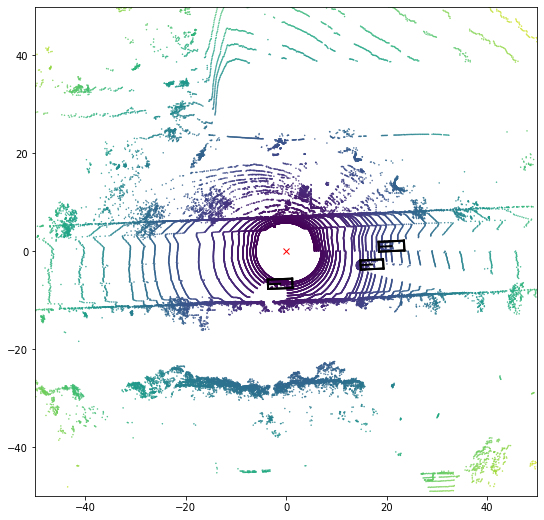

In [26]:
# plotting predicted and ground truth boxes on corresponding lidar point cloud
# pred boxes in lidar's FoR, we get the ground truth boxes in lidar's FoR too.
idx = 0
threshold = 0.7
pred_boxes = get_pred_boxes(pred, threshold, token)
info = token2info[token]
v_path = info["lidar_path"]

points = np.fromfile(v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
axes_limit = 50
_, ax = plt.subplots(1, 1, figsize=(9, 9))
dists = np.sqrt(np.sum(points[:, :2] ** 2, axis=1))
colors = np.minimum(1, dists / axes_limit / np.sqrt(2))
ax.scatter(points[:, 0], points[:, 1], c=colors, s=0.2)
ax.plot(0, 0, "x", color="red")
# Limit visible range.
ax.set_xlim(-axes_limit, axes_limit)
ax.set_ylim(-axes_limit, axes_limit)
for pbox in pred_boxes:
#     print(pbox)
    c = np.array(LyftDatasetExplorer.get_color('cone')) / 255.0 # black
    pbox.render(ax, view=np.eye(4), colors=(c, c, c))

In [18]:
info = token2info[token]
v_path = info["lidar_path"]
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]

In [258]:
sample = lyft.get('sample', info['token'])
lidar_token = sample['data']['LIDAR_TOP']
# lyft.render_sample_data(lidar_token)

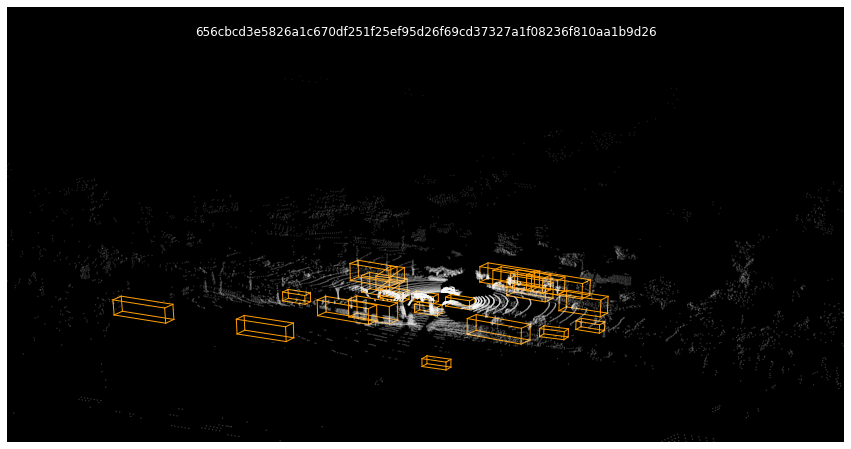

In [259]:
draw_3d_plot(lidar_token, boxes)

In [224]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

In [211]:
def draw_3d_plot(lidar_token, boxes):
    '''Plot the lidar + annotations on a 3D figure'''
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    #_, boxes, _ = lyft.get_sample_data(
    #    lidar_token, flat_vehicle_coordinates=True
    #)
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyft.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=1)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
#     filename = 'tmp/frame_{0:0>4}.png'.format(idx)
#     plt.savefig(filename)
#     plt.close(fig)
    plt.show()
#     return filename

In [182]:
def get_lidar_points(lidar_token):
    '''Get lidar point cloud in the frame of the ego vehicle'''
    sd_record = lyft.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    
    # Get aggregated point cloud in lidar frame.
    sample_rec = lyft.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        lyft, sample_rec, chan, ref_chan, num_sweeps=1
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = lyft.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = lyft.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]
    
    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

In [183]:
pc = get_lidar_points(sample['data']['LIDAR_TOP'])

In [123]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

In [ ]:
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
org_bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(org_bev_map.copy(), vis_point_range, boxes_lidar, [0, 255, 0], 2)

In [28]:
box3d_lidar = pred['box3d_lidar']
scores = pred['scores']
label_preds = pred['label_preds']
metadata = pred['metadata']

In [32]:
box3d_lidar.shape

torch.Size([188, 7])

In [29]:
label_preds

tensor([0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 6, 6, 2, 2, 6, 0, 0, 6, 6, 6, 2, 2,
        6, 6, 6, 6, 6, 6, 0, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6,
        6, 6, 2, 6, 2, 6, 6, 0, 6, 6, 6, 2, 2, 6, 6, 5, 6, 6, 6, 2, 2, 6, 6, 6,
        6, 2, 2, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 0, 6, 2, 6, 2, 6, 2, 6,
        6, 6, 6, 6, 5, 6, 6, 0, 6, 6, 0, 5, 2, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 2, 6, 6, 6, 0, 6, 6, 6, 6, 6, 2, 0, 6, 2, 2, 6, 6, 6, 6, 6, 0,
        0, 6, 6, 6, 2, 6, 6, 0, 2, 5, 0, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 2, 6, 2, 2, 6, 0, 6, 6, 2, 6, 6, 6, 2, 2, 6],
       device='cuda:0')

In [42]:
classes = target_assigner.classes

In [45]:

classes = target_assigner.classes
preds = [classes[x] for x in label_preds]
preds

['car',
 'car',
 'car',
 'car',
 'car',
 'bus',
 'bus',
 'bus',
 'car',
 'bus',
 'bus',
 'bus',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'car',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'car',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'car',


In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
img_id = train.iloc[0]['Id']
ps = train.iloc[0]['PredictionString']
ps = ps.split()
objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
len(objects), objects[0]

In [285]:
train.iloc[0]['PredictionString']

'2680.2830359778527 698.1969292852777 -18.04776692365821 2.064 5.488 2.053 2.6041643845397946 car 2691.997461646401 660.8016536569899 -18.674258695658377 1.818 4.57 1.608 -0.33517602468486984 car 2713.6075009338388 694.4034809694599 -18.589971933264334 1.779 4.992 1.62 2.579455758321168 car 2679.986916931015 706.9101495091695 -18.349594424165822 1.798 3.903 1.722 2.5861656766206993 car 2659.352095715659 719.4174623706303 -18.442998898501283 1.936 4.427 1.921 2.601798964714126 car 2705.199576267366 687.6053718669459 -18.13608710950738 1.849 4.586 1.801 2.6187666817281556 car 2712.706309822551 690.895857094069 -18.43179693610965 1.848 4.829 1.528 2.571936879901208 car 2755.5551865955817 646.2995181065994 -18.04141609089024 2.003 5.109 1.875 -0.5583518579067484 car 2721.868054568993 685.1596225679214 -17.64155351660436 2.539 7.671 3.287 2.609719767554756 truck 2723.602359479293 680.1666687198758 -17.298964332024624 2.557 7.637 3.594 2.598576712925146 truck 2683.980215118377 712.4764240778